## CODE:0 적절한 S값 찾기

* demo

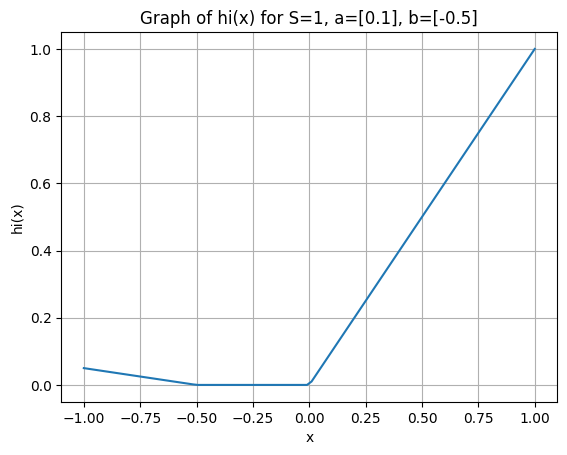

In [ ]:
# 참고
import matplotlib.pyplot as plt
import numpy as np

def hi(x, S, a, b):
    term1 = max(0, x)  # 첫 번째 항
    term2 = np.sum([a[s] * max(0, -x + b[s]) for s in range(S)])  # 두 번째 항의 합
    return term1 + term2

x_values = np.linspace(-1, 1, 100)  # x 값의 범위 지정
S = 1 # 합의 횟수
a = [0.1]  # 각 항의 가중치 (리스트 형태)
b = [-0.5]  # 각 항의 오프셋 (리스트 형태)

# S = 3  # 합의 횟수
# a = [0.2, 0.3, 0.1]  # 각 항의 가중치 (리스트 형태)
# b = [-0.5, 0.2, -0.1]  # 각 항의 오프셋 (리스트 형태)

y_values = [hi(x, S, a, b) for x in x_values]

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('hi(x)')
plt.title(f'Graph of hi(x) for S={S}, a={a}, b={b}')
plt.grid(True)
plt.show()

In [ ]:
# S=1 : 69.64 o
# S=2 : 77.53 o
# S=3 : 76.51
# S=4 : 81.24
# S=5 : 80.65 o
# S=10 : 81.33 o

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=1):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)

    def forward(self, x):
        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data

        return out

In [ ]:
# CIFAR10Model 클래스 정의
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.avgpool2 = nn.AvgPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)

        self.dropout_pool = nn.Dropout(p=0.25)
        self.dropout_fc = nn.Dropout(p=0.5)

        # APLLayer
        self.apl1 = APLLayer(96)
        self.apl2 = APLLayer(128)
        self.apl3 = APLLayer(256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.apl1(x)
        x = self.pool(x)
        x = self.dropout_pool(x)

        x = self.conv2(x)
        x = self.apl2(x)
        x = self.avgpool1(x)
        x = self.dropout_pool(x)

        x = self.conv3(x)
        x = self.apl3(x)
        x = self.avgpool2(x)
        x = self.dropout_pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.dropout_fc(x)

        x = self.fc2(x)
        x = self.dropout_fc(x)

        x = self.fc3(x)
        return x

In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

S=1일때

In [ ]:
# Initialize model, loss function, and optimizer
model = CIFAR10Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # L2 regularization

# Data loading and preprocessing
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Training the model
def train_model():
    model.train()
    for epoch in range(10):  # Adjust the number of epochs as needed
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Anomaly Detection 활성화
torch.autograd.set_detect_anomaly(True)

# 모델 학습 및 테스트
train_model()
test_model()

100%|██████████| 170498071/170498071 [00:12<00:00, 13126256.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Epoch 1, Iter 100] loss: 4.440
[Epoch 1, Iter 200] loss: 1.896
[Epoch 1, Iter 300] loss: 1.696
[Epoch 2, Iter 100] loss: 1.547
[Epoch 2, Iter 200] loss: 1.475
[Epoch 2, Iter 300] loss: 1.425
[Epoch 3, Iter 100] loss: 1.328
[Epoch 3, Iter 200] loss: 1.295
[Epoch 3, Iter 300] loss: 1.234
[Epoch 4, Iter 100] loss: 1.214
[Epoch 4, Iter 200] loss: 1.163
[Epoch 4, Iter 300] loss: 1.153
[Epoch 5, Iter 100] loss: 1.087
[Epoch 5, Iter 200] loss: 1.093
[Epoch 5, Iter 300] loss: 1.063
[Epoch 6, Iter 100] loss: 1.043
[Epoch 6, Iter 200] loss: 1.023
[Epoch 6, Iter 300] loss: 1.025
[Epoch 7, Iter 100] loss: 0.972
[Epoch 7, Iter 200] loss: 0.969
[Epoch 7, Iter 300] loss: 0.957
[Epoch 8, Iter 100] loss: 0.927
[Epoch 8, Iter 200] loss: 0.929
[Epoch 8, Iter 300] loss: 0.938
[Epoch 9, Iter 100] loss: 0.888
[Epoch 9, Iter 200] loss: 0.944
[Epoch 9, Iter 300] loss: 0.905
[Epoch 10, Iter 100] loss: 0.862
[Epoch 10, Ite

S=2일때

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=2):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)

    def forward(self, x):
        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data

        return out

In [ ]:
# Training the model
def train_model():
    model.train()
    for epoch in range(10):  # Adjust the number of epochs as needed
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Anomaly Detection 활성화
torch.autograd.set_detect_anomaly(True)

# 모델 학습 및 테스트
train_model()
test_model()

[Epoch 1, Iter 100] loss: 0.860
[Epoch 1, Iter 200] loss: 0.859
[Epoch 1, Iter 300] loss: 0.850
[Epoch 2, Iter 100] loss: 0.823
[Epoch 2, Iter 200] loss: 0.851
[Epoch 2, Iter 300] loss: 0.847
[Epoch 3, Iter 100] loss: 0.800
[Epoch 3, Iter 200] loss: 0.813
[Epoch 3, Iter 300] loss: 0.817
[Epoch 4, Iter 100] loss: 0.790
[Epoch 4, Iter 200] loss: 0.802
[Epoch 4, Iter 300] loss: 0.821
[Epoch 5, Iter 100] loss: 0.795
[Epoch 5, Iter 200] loss: 0.776
[Epoch 5, Iter 300] loss: 0.776
[Epoch 6, Iter 100] loss: 0.776
[Epoch 6, Iter 200] loss: 0.775
[Epoch 6, Iter 300] loss: 0.754
[Epoch 7, Iter 100] loss: 0.753
[Epoch 7, Iter 200] loss: 0.732
[Epoch 7, Iter 300] loss: 0.769
[Epoch 8, Iter 100] loss: 0.734
[Epoch 8, Iter 200] loss: 0.759
[Epoch 8, Iter 300] loss: 0.761
[Epoch 9, Iter 100] loss: 0.734
[Epoch 9, Iter 200] loss: 0.747
[Epoch 9, Iter 300] loss: 0.742
[Epoch 10, Iter 100] loss: 0.738
[Epoch 10, Iter 200] loss: 0.705
[Epoch 10, Iter 300] loss: 0.722
Accuracy of the network on the 10000 

S=3일때

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=3):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)

    def forward(self, x):
        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data

        return out

In [ ]:
# Training the model
def train_model():
    model.train()
    for epoch in range(10):  # Adjust the number of epochs as needed
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Anomaly Detection 활성화
torch.autograd.set_detect_anomaly(True)

# 모델 학습 및 테스트
train_model()
test_model()

[Epoch 1, Iter 100] loss: 0.705
[Epoch 1, Iter 200] loss: 0.732
[Epoch 1, Iter 300] loss: 0.717
[Epoch 2, Iter 100] loss: 0.708
[Epoch 2, Iter 200] loss: 0.699
[Epoch 2, Iter 300] loss: 0.720
[Epoch 3, Iter 100] loss: 0.689
[Epoch 3, Iter 200] loss: 0.720
[Epoch 3, Iter 300] loss: 0.709
[Epoch 4, Iter 100] loss: 0.697
[Epoch 4, Iter 200] loss: 0.693
[Epoch 4, Iter 300] loss: 0.713
[Epoch 5, Iter 100] loss: 0.693
[Epoch 5, Iter 200] loss: 0.687
[Epoch 5, Iter 300] loss: 0.699
[Epoch 6, Iter 100] loss: 0.673
[Epoch 6, Iter 200] loss: 0.694
[Epoch 6, Iter 300] loss: 0.671
[Epoch 7, Iter 100] loss: 0.687
[Epoch 7, Iter 200] loss: 0.677
[Epoch 7, Iter 300] loss: 0.696
[Epoch 8, Iter 100] loss: 0.673
[Epoch 8, Iter 200] loss: 0.674
[Epoch 8, Iter 300] loss: 0.691
[Epoch 9, Iter 100] loss: 0.665
[Epoch 9, Iter 200] loss: 0.672
[Epoch 9, Iter 300] loss: 0.676
[Epoch 10, Iter 100] loss: 0.664
[Epoch 10, Iter 200] loss: 0.655
[Epoch 10, Iter 300] loss: 0.689
Accuracy of the network on the 10000 

S=4일때

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=4):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)

    def forward(self, x):
        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data

        return out

In [ ]:
# Training the model
def train_model():
    model.train()
    for epoch in range(10):  # Adjust the number of epochs as needed
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Anomaly Detection 활성화
torch.autograd.set_detect_anomaly(True)

# 모델 학습 및 테스트
train_model()
test_model()

[Epoch 1, Iter 100] loss: 0.665
[Epoch 1, Iter 200] loss: 0.662
[Epoch 1, Iter 300] loss: 0.679
[Epoch 2, Iter 100] loss: 0.657
[Epoch 2, Iter 200] loss: 0.667
[Epoch 2, Iter 300] loss: 0.657
[Epoch 3, Iter 100] loss: 0.647
[Epoch 3, Iter 200] loss: 0.657
[Epoch 3, Iter 300] loss: 0.676
[Epoch 4, Iter 100] loss: 0.648
[Epoch 4, Iter 200] loss: 0.664
[Epoch 4, Iter 300] loss: 0.671
[Epoch 5, Iter 100] loss: 0.661
[Epoch 5, Iter 200] loss: 0.651
[Epoch 5, Iter 300] loss: 0.652
[Epoch 6, Iter 100] loss: 0.637
[Epoch 6, Iter 200] loss: 0.661
[Epoch 6, Iter 300] loss: 0.671
[Epoch 7, Iter 100] loss: 0.657
[Epoch 7, Iter 200] loss: 0.661
[Epoch 7, Iter 300] loss: 0.661
[Epoch 8, Iter 100] loss: 0.631
[Epoch 8, Iter 200] loss: 0.640
[Epoch 8, Iter 300] loss: 0.655
[Epoch 9, Iter 100] loss: 0.635
[Epoch 9, Iter 200] loss: 0.659
[Epoch 9, Iter 300] loss: 0.639
[Epoch 10, Iter 100] loss: 0.639
[Epoch 10, Iter 200] loss: 0.655
[Epoch 10, Iter 300] loss: 0.642
Accuracy of the network on the 10000 

S=5일때

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=5):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)

    def forward(self, x):
        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data

        return out

In [ ]:
# Training the model
def train_model():
    model.train()
    for epoch in range(10):  # Adjust the number of epochs as needed
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Anomaly Detection 활성화
torch.autograd.set_detect_anomaly(True)

# 모델 학습 및 테스트
train_model()
test_model()

[Epoch 1, Iter 100] loss: 0.633
[Epoch 1, Iter 200] loss: 0.653
[Epoch 1, Iter 300] loss: 0.646
[Epoch 2, Iter 100] loss: 0.647
[Epoch 2, Iter 200] loss: 0.657
[Epoch 2, Iter 300] loss: 0.640
[Epoch 3, Iter 100] loss: 0.610
[Epoch 3, Iter 200] loss: 0.646
[Epoch 3, Iter 300] loss: 0.623
[Epoch 4, Iter 100] loss: 0.641
[Epoch 4, Iter 200] loss: 0.630
[Epoch 4, Iter 300] loss: 0.638
[Epoch 5, Iter 100] loss: 0.642
[Epoch 5, Iter 200] loss: 0.645
[Epoch 5, Iter 300] loss: 0.648
[Epoch 6, Iter 100] loss: 0.631
[Epoch 6, Iter 200] loss: 0.645
[Epoch 6, Iter 300] loss: 0.618
[Epoch 7, Iter 100] loss: 0.632
[Epoch 7, Iter 200] loss: 0.639
[Epoch 7, Iter 300] loss: 0.634
[Epoch 8, Iter 100] loss: 0.634
[Epoch 8, Iter 200] loss: 0.608
[Epoch 8, Iter 300] loss: 0.640
[Epoch 9, Iter 100] loss: 0.607
[Epoch 9, Iter 200] loss: 0.621
[Epoch 9, Iter 300] loss: 0.643
[Epoch 10, Iter 100] loss: 0.618
[Epoch 10, Iter 200] loss: 0.640
[Epoch 10, Iter 300] loss: 0.625
Accuracy of the network on the 10000 

S=10일때

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=10):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)

    def forward(self, x):
        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data

        return out

## CODE:1 APLunit vs relu vs leaky relu

In [ ]:
# Data loading and preprocessing
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 41775143.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


* 논문과 비슷한 꼴을 유지하려고 함
* data augmentation 적용한 버전
* dropout 부분이 논문과 다름

In [ ]:
## 유의미한 결론
# 훈련 loss의 초기 값은 relu와 leakyrelu가 확실히 낮고 안정적임.
# 하지만 에포크를 반복할수록 APLLayer를 정의한 모델의 빠르게 성능이 높아짐

* APL unit (우리의 제안)

In [ ]:
# APLLayer 클래스 정의
class APLLayer(nn.Module):
    def __init__(self, num_features, num_sums=5):
        super(APLLayer, self).__init__()
        self.num_features = num_features
        self.num_sums = num_sums

        # 가중치와 오프셋 초기화
        self.neuron_weight = nn.Parameter(torch.Tensor(num_features, num_sums))
        self.neuron_offset = nn.Parameter(torch.Tensor(1, num_features, 1, 1, num_sums))

        # 파라미터 초기화
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.neuron_weight, a=math.sqrt(5))
        nn.init.zeros_(self.neuron_offset)
    def forward(self, x):

        # ReLU 부분
        out = F.relu(x)

        # 학습된 가중치와 오프셋을 사용한 음수 부분
        for s in range(self.num_sums):
            max_data = torch.clamp(-x + self.neuron_offset[:, :, :, :, s], min=0)
            out = out + self.neuron_weight[:, s].view(1, -1, 1, 1) * max_data
        return out

In [ ]:
# CIFAR10Model 클래스 정의
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.avgpool2 = nn.AvgPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)

        self.dropout_pool = nn.Dropout(p=0.25)
        self.dropout_fc = nn.Dropout(p=0.5)

        # APLLayer
        self.apl1 = APLLayer(96)
        self.apl2 = APLLayer(128)
        self.apl3 = APLLayer(256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.apl1(x)
        x = self.pool(x)
        x = self.dropout_pool(x)

        x = self.conv2(x)
        x = self.apl2(x)
        x = self.avgpool1(x)
        x = self.dropout_pool(x)

        x = self.conv3(x)
        x = self.apl3(x)
        x = self.avgpool2(x)
        x = self.dropout_pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.dropout_fc(x)

        x = self.fc2(x)
        x = self.dropout_fc(x)

        x = self.fc3(x)
        return x

In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model, loss function, and optimizer
model = CIFAR10Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # L2 regularization

In [ ]:
# 약 10분 소요

Epoch 1/10: 100%|██████████| 391/391 [00:32<00:00, 12.07batch/s]


Epoch 1/10, Train Loss: 2.0337, Test Loss: 1.4788, Accuracy: 46.13%


Epoch 2/10: 100%|██████████| 391/391 [00:31<00:00, 12.46batch/s]


Epoch 2/10, Train Loss: 1.3796, Test Loss: 1.1789, Accuracy: 57.77%


Epoch 3/10: 100%|██████████| 391/391 [00:31<00:00, 12.49batch/s]


Epoch 3/10, Train Loss: 1.1776, Test Loss: 1.0306, Accuracy: 63.36%


Epoch 4/10: 100%|██████████| 391/391 [00:31<00:00, 12.50batch/s]


Epoch 4/10, Train Loss: 1.0259, Test Loss: 0.9201, Accuracy: 68.07%


Epoch 5/10: 100%|██████████| 391/391 [00:32<00:00, 11.97batch/s]


Epoch 5/10, Train Loss: 0.9474, Test Loss: 0.8590, Accuracy: 70.19%


Epoch 6/10: 100%|██████████| 391/391 [00:32<00:00, 12.13batch/s]


Epoch 6/10, Train Loss: 0.8712, Test Loss: 0.8104, Accuracy: 71.70%


Epoch 7/10: 100%|██████████| 391/391 [00:31<00:00, 12.47batch/s]


Epoch 7/10, Train Loss: 0.8462, Test Loss: 0.7766, Accuracy: 74.03%


Epoch 8/10: 100%|██████████| 391/391 [00:35<00:00, 11.12batch/s]


Epoch 8/10, Train Loss: 0.8071, Test Loss: 0.7342, Accuracy: 74.99%


Epoch 9/10: 100%|██████████| 391/391 [00:31<00:00, 12.44batch/s]


Epoch 9/10, Train Loss: 0.7797, Test Loss: 0.7504, Accuracy: 74.93%


Epoch 10/10: 100%|██████████| 391/391 [00:31<00:00, 12.34batch/s]


Epoch 10/10, Train Loss: 0.7619, Test Loss: 0.7134, Accuracy: 75.98%


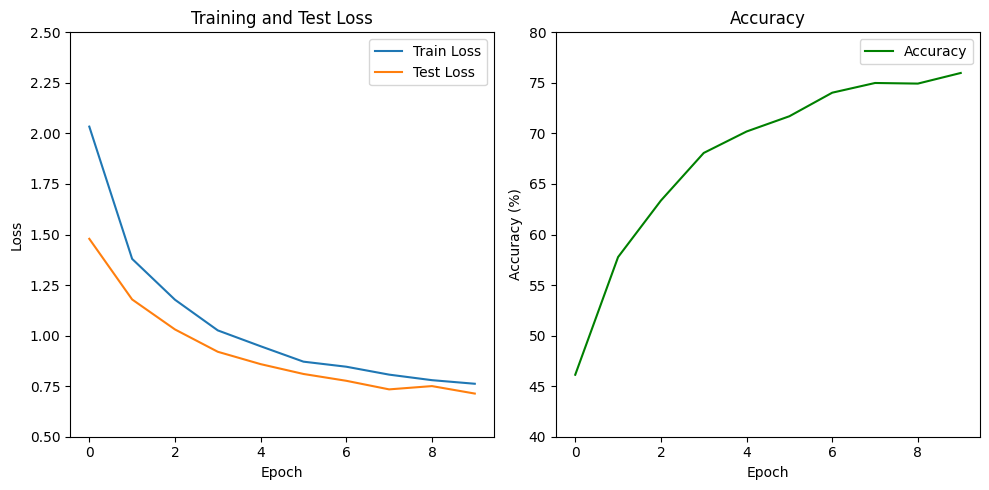

In [ ]:
# Directory for saving parameters
if not os.path.exists('apl_params'):
    os.makedirs('apl_params')

# Save initial parameters before training
torch.save(model.apl1.state_dict(), 'apl_params/apl1_epoch_0.pth')
torch.save(model.apl2.state_dict(), 'apl_params/apl2_epoch_0.pth')
torch.save(model.apl3.state_dict(), 'apl_params/apl3_epoch_0.pth')

# 학습 함수 정의
def train(epoch):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에포크 동안의 누적 손실
    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        # 배치 데이터를 장치로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()  # 손실 누적

    train_loss = running_loss / len(trainloader)  # 에포크 당 평균 손실 계산
    return train_loss  # 학습 손실 반환

# 평가 함수 정의
def test(epoch):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0  # 맞춘 샘플 수
    total = 0  # 전체 샘플 수
    test_loss = 0.0  # 테스트 손실
    with torch.no_grad():  # 기울기 계산 비활성화 (메모리 절약)
        for inputs, labels in testloader:
            # 배치 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # 모델 예측
            loss = criterion(outputs, labels)  # 손실 계산
            test_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs, 1)  # 예측값에서 가장 높은 값 선택
            total += labels.size(0)  # 전체 샘플 수 누적
            correct += (predicted == labels).sum().item()  # 맞춘 샘플 수 누적

    accuracy = 100 * correct / total  # 정확도 계산
    test_loss /= len(testloader)  # 평균 테스트 손실 계산
    return accuracy, test_loss  # 정확도와 테스트 손실 반환

# 하이퍼파라미터 설정 및 학습 실행
epochs = 10  # 학습할 에포크 수
train_losses = []  # 학습 손실 저장 리스트
test_losses = []  # 테스트 손실 저장 리스트
accuracies = []  # 정확도 저장 리스트

for epoch in range(epochs):
    train_loss = train(epoch)  # 학습 함수 호출
    accuracy, test_loss = test(epoch)  # 평가 함수 호출

    train_losses.append(train_loss)  # 학습 손실 저장
    test_losses.append(test_loss)  # 테스트 손실 저장
    accuracies.append(accuracy)  # 정확도 저장

    # 에포크별로 APL 레이어 파라미터 저장
    torch.save(model.apl1.state_dict(), f'apl_params/apl1_epoch_{epoch + 1}.pth')
    torch.save(model.apl2.state_dict(), f'apl_params/apl2_epoch_{epoch + 1}.pth')
    torch.save(model.apl3.state_dict(), f'apl_params/apl3_epoch_{epoch + 1}.pth')

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

# 시각화
plt.figure(figsize=(10, 5))

# Training and Test Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')  # 학습 손실 그래프
plt.plot(test_losses, label='Test Loss')  # 테스트 손실 그래프
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.ylim(0.5, 2.5)  # 세로축 범위를 0.5에서 2.5로 고정

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')  # 정확도 그래프
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.ylim(40, 80)  # 세로축 범위를 40에서 80으로 고정

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

* relu

In [ ]:
class CIFAR10ModelReLU(nn.Module):
    def __init__(self):
        super(CIFAR10ModelReLU, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.avgpool2 = nn.AvgPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)

        self.dropout_pool = nn.Dropout(p=0.25)
        self.dropout_fc = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)  # ReLU activation
        x = self.pool(x)
        x = self.dropout_pool(x)

        x = self.conv2(x)
        x = F.relu(x)  # ReLU activation
        x = self.avgpool1(x)
        x = self.dropout_pool(x)

        x = self.conv3(x)
        x = F.relu(x)  # ReLU activation
        x = self.avgpool2(x)
        x = self.dropout_pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = F.relu(x)  # ReLU activation
        x = self.dropout_fc(x)

        x = self.fc2(x)
        x = F.relu(x)  # ReLU activation
        x = self.dropout_fc(x)

        x = self.fc3(x)
        return x

In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model, loss function, and optimizer
model = CIFAR10ModelReLU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # L2 regularization

Epoch 1/10: 100%|██████████| 391/391 [00:23<00:00, 16.60batch/s]


Epoch 1/10, Train Loss: 1.2797, Test Loss: 1.1751, Accuracy: 58.04%


Epoch 2/10: 100%|██████████| 391/391 [00:24<00:00, 15.84batch/s]


Epoch 2/10, Train Loss: 1.2688, Test Loss: 1.1540, Accuracy: 58.29%


Epoch 3/10: 100%|██████████| 391/391 [00:24<00:00, 16.13batch/s]


Epoch 3/10, Train Loss: 1.2602, Test Loss: 1.1538, Accuracy: 58.90%


Epoch 4/10: 100%|██████████| 391/391 [00:24<00:00, 16.11batch/s]


Epoch 4/10, Train Loss: 1.2538, Test Loss: 1.1396, Accuracy: 59.47%


Epoch 5/10: 100%|██████████| 391/391 [00:24<00:00, 15.94batch/s]


Epoch 5/10, Train Loss: 1.2462, Test Loss: 1.1349, Accuracy: 59.68%


Epoch 6/10: 100%|██████████| 391/391 [00:23<00:00, 16.35batch/s]


Epoch 6/10, Train Loss: 1.2287, Test Loss: 1.0952, Accuracy: 60.71%


Epoch 7/10: 100%|██████████| 391/391 [00:23<00:00, 16.47batch/s]


Epoch 7/10, Train Loss: 1.2235, Test Loss: 1.1131, Accuracy: 60.16%


Epoch 8/10: 100%|██████████| 391/391 [00:23<00:00, 16.40batch/s]


Epoch 8/10, Train Loss: 1.2190, Test Loss: 1.1195, Accuracy: 60.39%


Epoch 9/10: 100%|██████████| 391/391 [00:24<00:00, 15.94batch/s]


Epoch 9/10, Train Loss: 1.2084, Test Loss: 1.0942, Accuracy: 61.42%


Epoch 10/10: 100%|██████████| 391/391 [00:23<00:00, 16.82batch/s]


Epoch 10/10, Train Loss: 1.2036, Test Loss: 1.0956, Accuracy: 60.75%


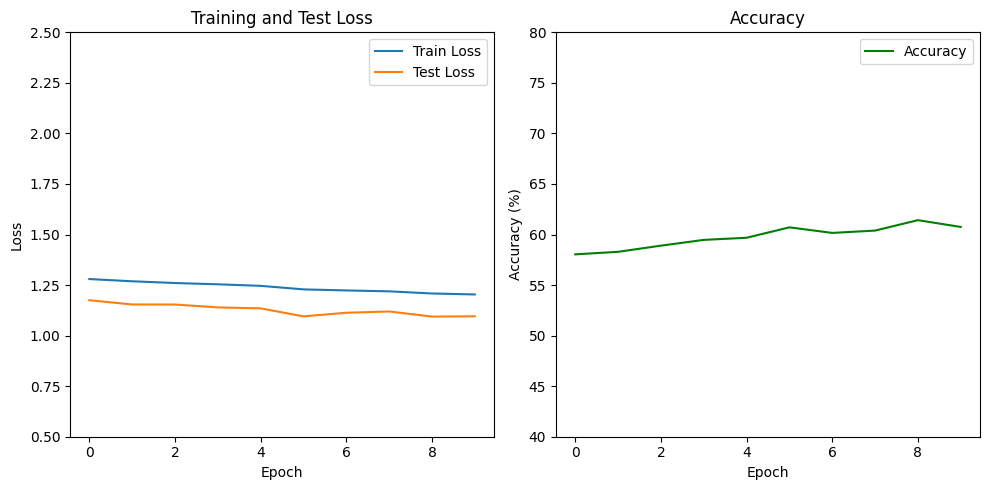

In [ ]:
# 학습 함수 정의
def train(epoch):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에포크 동안의 누적 손실
    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        # 배치 데이터를 장치로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()  # 손실 누적

    train_loss = running_loss / len(trainloader)  # 에포크 당 평균 손실 계산
    return train_loss  # 학습 손실 반환

# 평가 함수 정의
def test(epoch):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0  # 맞춘 샘플 수
    total = 0  # 전체 샘플 수
    test_loss = 0.0  # 테스트 손실
    with torch.no_grad():  # 기울기 계산 비활성화 (메모리 절약)
        for inputs, labels in testloader:
            # 배치 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # 모델 예측
            loss = criterion(outputs, labels)  # 손실 계산
            test_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs, 1)  # 예측값에서 가장 높은 값 선택
            total += labels.size(0)  # 전체 샘플 수 누적
            correct += (predicted == labels).sum().item()  # 맞춘 샘플 수 누적

    accuracy = 100 * correct / total  # 정확도 계산
    test_loss /= len(testloader)  # 평균 테스트 손실 계산
    return accuracy, test_loss  # 정확도와 테스트 손실 반환

# 하이퍼파라미터 설정 및 학습 실행
epochs = 10  # 학습할 에포크 수
train_losses = []  # 학습 손실 저장 리스트
test_losses = []  # 테스트 손실 저장 리스트
accuracies = []  # 정확도 저장 리스트

for epoch in range(epochs):
    train_loss = train(epoch)  # 학습 함수 호출
    accuracy, test_loss = test(epoch)  # 평가 함수 호출

    train_losses.append(train_loss)  # 학습 손실 저장
    test_losses.append(test_loss)  # 테스트 손실 저장
    accuracies.append(accuracy)  # 정확도 저장

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

# 시각화
plt.figure(figsize=(10, 5))

# Training and Test Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')  # 학습 손실 그래프
plt.plot(test_losses, label='Test Loss')  # 테스트 손실 그래프
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.ylim(0.5, 2.5)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')  # 정확도 그래프
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.ylim(40, 80)  # 세로축 범위를 40에서 80으로 고정

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

* leaky-relu

In [ ]:
import torch.nn.functional as F

class CIFAR10ModelLeakyReLU(nn.Module):
    def __init__(self):
        super(CIFAR10ModelLeakyReLU, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.avgpool2 = nn.AvgPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)

        self.dropout_pool = nn.Dropout(p=0.25)
        self.dropout_fc = nn.Dropout(p=0.5)

        # LeakyReLU activation
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)  # LeakyReLU activation
        x = self.pool(x)
        x = self.dropout_pool(x)

        x = self.conv2(x)
        x = self.leakyrelu(x)  # LeakyReLU activation
        x = self.avgpool1(x)
        x = self.dropout_pool(x)

        x = self.conv3(x)
        x = self.leakyrelu(x)  # LeakyReLU activation
        x = self.avgpool2(x)
        x = self.dropout_pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.leakyrelu(x)  # LeakyReLU activation
        x = self.dropout_fc(x)

        x = self.fc2(x)
        x = self.leakyrelu(x)  # LeakyReLU activation
        x = self.dropout_fc(x)

        x = self.fc3(x)
        return x

In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model, loss function, and optimizer
model = CIFAR10ModelLeakyReLU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # L2 regularization

In [ ]:
# 약 5분 소요

Epoch 1/10: 100%|██████████| 391/391 [00:23<00:00, 16.44batch/s]


Epoch 1/10, Train Loss: 1.7447, Test Loss: 1.4774, Accuracy: 46.02%


Epoch 2/10: 100%|██████████| 391/391 [00:23<00:00, 16.52batch/s]


Epoch 2/10, Train Loss: 1.3842, Test Loss: 1.2405, Accuracy: 55.66%


Epoch 3/10: 100%|██████████| 391/391 [00:23<00:00, 16.51batch/s]


Epoch 3/10, Train Loss: 1.2324, Test Loss: 1.0935, Accuracy: 61.30%


Epoch 4/10: 100%|██████████| 391/391 [00:25<00:00, 15.49batch/s]


Epoch 4/10, Train Loss: 1.1325, Test Loss: 1.0110, Accuracy: 64.37%


Epoch 5/10: 100%|██████████| 391/391 [00:22<00:00, 17.11batch/s]


Epoch 5/10, Train Loss: 1.0650, Test Loss: 0.9370, Accuracy: 67.55%


Epoch 6/10: 100%|██████████| 391/391 [00:23<00:00, 16.43batch/s]


Epoch 6/10, Train Loss: 1.0022, Test Loss: 0.8961, Accuracy: 68.74%


Epoch 7/10: 100%|██████████| 391/391 [00:24<00:00, 16.24batch/s]


Epoch 7/10, Train Loss: 0.9760, Test Loss: 0.9105, Accuracy: 67.78%


Epoch 8/10: 100%|██████████| 391/391 [00:24<00:00, 16.18batch/s]


Epoch 8/10, Train Loss: 0.9606, Test Loss: 0.8739, Accuracy: 69.86%


Epoch 9/10: 100%|██████████| 391/391 [00:24<00:00, 16.29batch/s]


Epoch 9/10, Train Loss: 0.9307, Test Loss: 0.8507, Accuracy: 70.48%


Epoch 10/10: 100%|██████████| 391/391 [00:23<00:00, 16.43batch/s]


Epoch 10/10, Train Loss: 0.9106, Test Loss: 0.8923, Accuracy: 70.08%


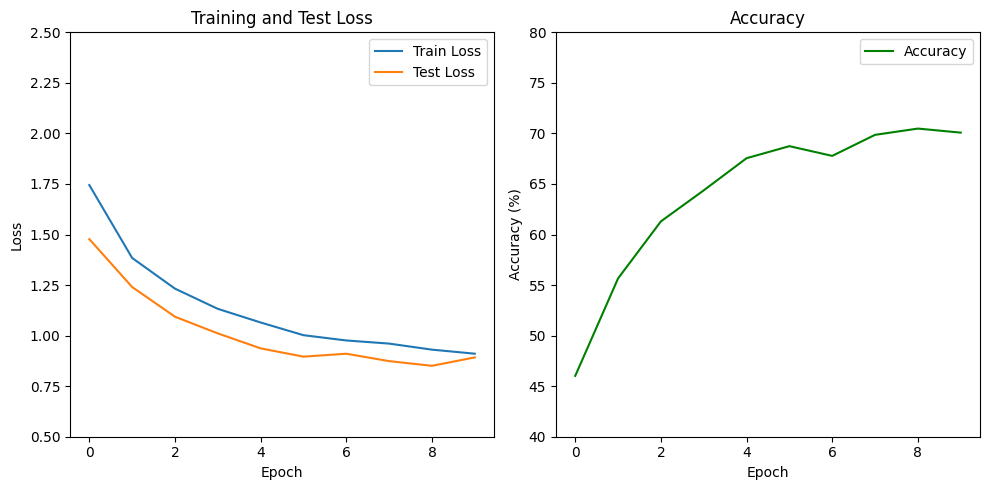

In [ ]:
# 학습 함수 정의
def train(epoch):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에포크 동안의 누적 손실
    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        # 배치 데이터를 장치로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()  # 손실 누적

    train_loss = running_loss / len(trainloader)  # 에포크 당 평균 손실 계산
    return train_loss  # 학습 손실 반환

# 평가 함수 정의
def test(epoch):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0  # 맞춘 샘플 수
    total = 0  # 전체 샘플 수
    test_loss = 0.0  # 테스트 손실
    with torch.no_grad():  # 기울기 계산 비활성화 (메모리 절약)
        for inputs, labels in testloader:
            # 배치 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # 모델 예측
            loss = criterion(outputs, labels)  # 손실 계산
            test_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs, 1)  # 예측값에서 가장 높은 값 선택
            total += labels.size(0)  # 전체 샘플 수 누적
            correct += (predicted == labels).sum().item()  # 맞춘 샘플 수 누적

    accuracy = 100 * correct / total  # 정확도 계산
    test_loss /= len(testloader)  # 평균 테스트 손실 계산
    return accuracy, test_loss  # 정확도와 테스트 손실 반환

# 하이퍼파라미터 설정 및 학습 실행
epochs = 10  # 학습할 에포크 수
train_losses = []  # 학습 손실 저장 리스트
test_losses = []  # 테스트 손실 저장 리스트
accuracies = []  # 정확도 저장 리스트

for epoch in range(epochs):
    train_loss = train(epoch)  # 학습 함수 호출
    accuracy, test_loss = test(epoch)  # 평가 함수 호출

    train_losses.append(train_loss)  # 학습 손실 저장
    test_losses.append(test_loss)  # 테스트 손실 저장
    accuracies.append(accuracy)  # 정확도 저장

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

# 시각화
plt.figure(figsize=(10, 5))

# Training and Test Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')  # 학습 손실 그래프
plt.plot(test_losses, label='Test Loss')  # 테스트 손실 그래프
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.ylim(0.5, 2.5)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')  # 정확도 그래프
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.ylim(40, 80)  # 세로축 범위를 40에서 80으로 고정

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

## CODE:2 APL unit Visualization

In [ ]:
# 유의미한 결론
# S=5인게 elu처럼 곡선처럼 보이는 효과 있음
# 수렴할수록 렐루 꼴과 닮아가는데 leaky relu처럼 아래로 약간 꺾이는 꼴도 있고 위로 약간 꺾이는 꼴도 있음
# 논문에서는 대다수 위로 약간 꺾이는 꼴이라고 함
# 확실한 V자 개형도 보임 (convex한 꼴의 활성화함수를 잘 안쓰는 이유는 뭘까?하는 궁금증이 남음)

In [ ]:
# # 참고
# # APL 레이어 파라미터 파일 경로 설정
# file_path = '/content/apl_params/apl1_epoch_1.pth'

# # 저장된 파라미터 파일 불러오기
# state_dict = torch.load(file_path) # GPU가 아닌 CPU에서 실행할 경우에는 map_location='cpu' 추가

# # 첫 번째 뉴런의 가중치와 오프셋 값 가져오기
# first_neuron_weight = state_dict['neuron_weight'][0].tolist() # tensor를 리스트로 변환
# first_neuron_offset = state_dict['neuron_offset'][0][0][0].tolist() # tensor를 리스트로 변환

# print("첫 번째 뉴런의 가중치:", first_neuron_weight)
# print("첫 번째 뉴런의 오프셋:", first_neuron_offset[0])

첫 번째 뉴런의 가중치: [-0.25005972385406494, 0.2854042649269104, 0.17139576375484467, -0.03429160639643669, 0.08072199672460556]
첫 번째 뉴런의 오프셋: [0.04690570384263992, -0.04363081976771355, -0.04187159612774849, 0.037964802235364914, -0.03774528577923775]


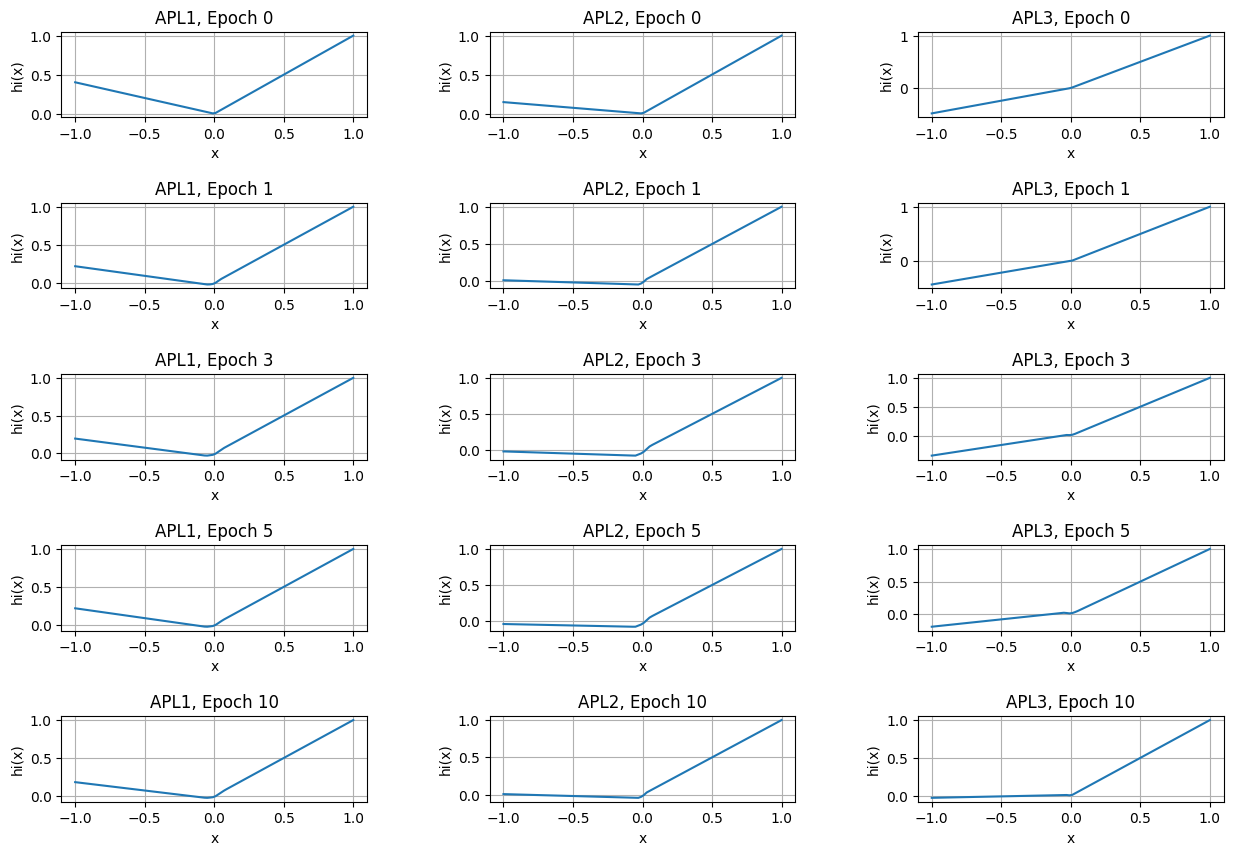

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 활성화 함수 정의
def hi(x, S, a, b):
    term1 = max(0, x)  # 첫 번째 항
    term2 = np.sum([a[s] * max(0, -x + b[s]) for s in range(S)])  # 두 번째 항의 합
    return term1 + term2

# 에포크 및 APL 레이어 설정
epochs = [0, 1, 3, 5, 10]
apl_layers = [1, 2, 3]

# x 값의 범위 지정
x_values = np.linspace(-1, 1, 100)

# 그래프를 그리기 위한 설정
fig, axs = plt.subplots(len(epochs), len(apl_layers), figsize=(15, 10))  # subplots으로 여러 그래프 생성
fig.subplots_adjust(hspace=1, wspace=0.4)  # 그래프 간격 조정

for i, epoch in enumerate(epochs):
    for j, apl in enumerate(apl_layers):
        file_path = f'/content/apl_params/apl{apl}_epoch_{epoch}.pth'
        state_dict = torch.load(file_path)

        # 첫 번째 뉴런의 가중치와 오프셋 값 가져오기
        a = state_dict['neuron_weight'][0].tolist()
        b = state_dict['neuron_offset'][0][0][0].tolist()
        b = b[0]

        # 활성화 함수 계산
        y_values = [hi(x, 5, a, b) for x in x_values]

        # 현재 subplot에 그래프 그리기
        axs[i, j].plot(x_values, y_values)
        axs[i, j].set_title(f'APL{apl}, Epoch {epoch}')
        axs[i, j].set_xlabel('x')
        axs[i, j].set_ylabel('hi(x)')
        axs[i, j].grid(True)

# 전체 그래프 보여주기
plt.show()

## CODE:3 If the depth of the model deepens, what will the gap be?

In [ ]:
# 약 1시간 소요

In [ ]:
# 모델 정의
class Net(nn.Module):
    def __init__(self, num_layers, activation_func):
        super(Net, self).__init__()
        layers = [nn.Conv2d(3, 64, kernel_size=3, padding=1)]
        for _ in range(num_layers - 1):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            if activation_func == 'apllayer':
                layers.append(APLLayer(64))
            elif activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'leakyrelu':
                layers.append(nn.LeakyReLU())
        layers.append(nn.AdaptiveAvgPool2d(1))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(64, 10))
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        return x

Training 3-layer network with apllayer
Training 3-layer network with relu
Training 3-layer network with leakyrelu
Training 5-layer network with apllayer
Training 5-layer network with relu
Training 5-layer network with leakyrelu
Training 7-layer network with apllayer
Training 7-layer network with relu
Training 7-layer network with leakyrelu


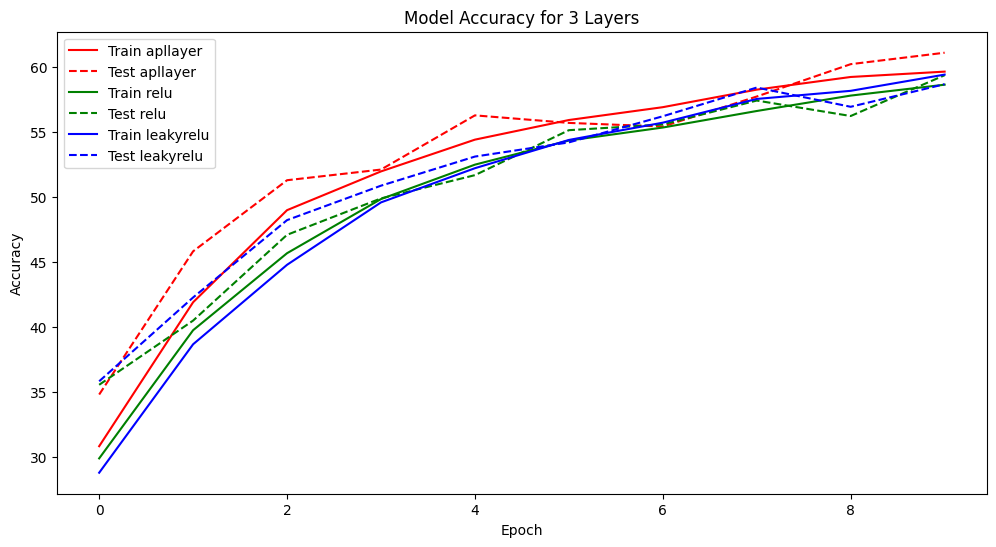

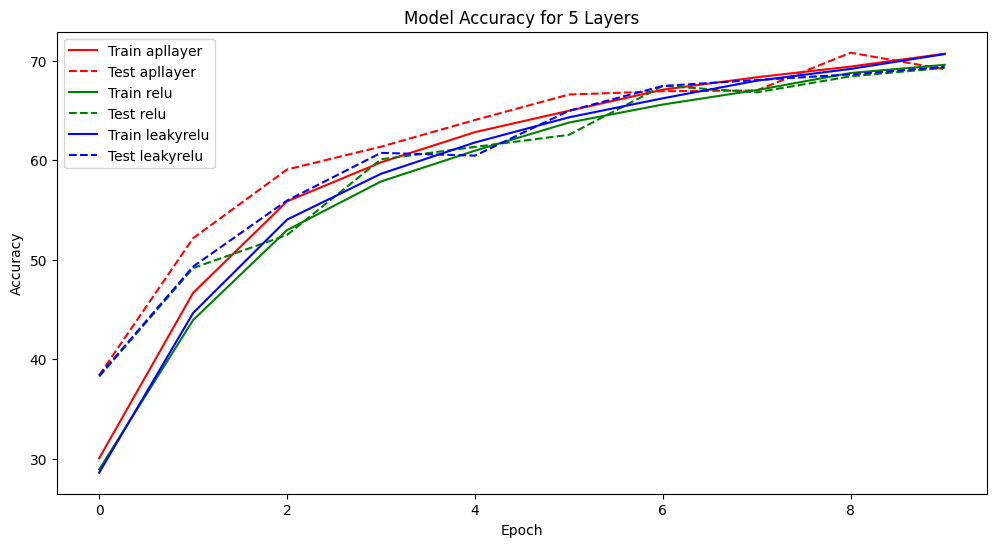

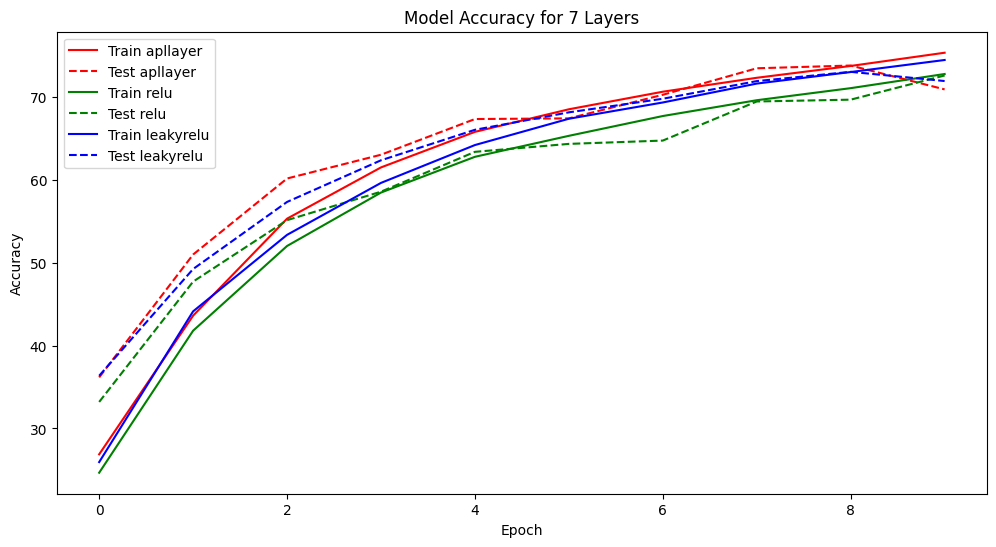

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss / batch_idx, 100. * correct / total

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return test_loss / batch_idx, 100. * correct / total

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델, 최적화기, 에폭 설정
num_epochs = 10  # 실제 사용 시 적절한 에폭으로 설정
activations = ['apllayer', 'relu', 'leakyrelu']
num_layers_list = [3, 5, 7]
colors = ['r', 'g', 'b']
linestyles = ['-', '--']

# 결과 저장을 위한 딕셔너리
results = {}

for num_layers in num_layers_list:
    results[num_layers] = {}
    for activation in activations:
        print(f"Training {num_layers}-layer network with {activation}")
        model = Net(num_layers, activation).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_accuracies = []
        test_accuracies = []
        for epoch in range(num_epochs):
            train_loss, train_acc = train(model, device, trainloader, optimizer, epoch)
            test_loss, test_acc = test(model, device, testloader)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

        results[num_layers][activation] = {'train_acc': train_accuracies, 'test_acc': test_accuracies}

# 결과 시각화
for num_layers in num_layers_list:
    plt.figure(figsize=(12, 6))
    plt.title(f"Model Accuracy for {num_layers} Layers")
    for i, activation in enumerate(activations):
        plt.plot(results[num_layers][activation]['train_acc'], color=colors[i], linestyle=linestyles[0], label=f"Train {activation}")
        plt.plot(results[num_layers][activation]['test_acc'], color=colors[i], linestyle=linestyles[1], label=f"Test {activation}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
